<a href="https://colab.research.google.com/github/Henning-Kubatzsch/Tutorials/blob/main/Makemore/01_MakeMoreShort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Makemore-01

A simple bigram character-level language model is implemented as a foundation for building more complex models like Transformers. The focus lies on two main aspects:

Efficient use of torch.Tensor for neural network computation
Core components of language modeling: training, sampling, and loss evaluation
Key Steps:

Load and explore the dataset
Count character bigrams using a dictionary and a 2D tensor
Visualize the bigram probability matrix
Clean the dataset by unifying start/end tokens
Sample new text from the model
Improve efficiency using tensor broadcasting and vectorized normalization
Define the negative log likelihood loss function
Apply model smoothing with fake counts
Neural Network Extension:

Prepare a bigram dataset for a neural network
Represent inputs as one-hot vectors
Use a single linear layer (matrix multiplication) to predict the next character
Apply softmax to produce probability distributions
Compute a vectorized loss
Perform backpropagation and parameter updates using PyTorch
Reinterpret one-hot encoding as direct row selection in the weight matrix
Add smoothing as a form of regularization
Sample from the neural network model
This forms a minimal yet functional neural language model, setting the stage for future improvements.

# Load Dataset

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt -O names.txt
words = open('names.txt').read().splitlines()

--2025-05-30 13:13:05--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.1s    

2025-05-30 13:13:06 (1.45 MB/s) - ‘names.txt’ saved [228145/228145]



# Lookup functions

In [ ]:
import torch
chars = sorted(list(set(''.join(words))))

In [ ]:
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

In [ ]:
stoi['.']

0

In [ ]:
itos = {i:s for s,i in stoi.items()}

# Create Bigram N for transitions

In [ ]:
N = torch.zeros((27,27), dtype = torch.int32)

b = {}
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    x1 = stoi[ch1]
    x2 = stoi[ch2]
    N[x1][x2] += 1

# The Chart 📊

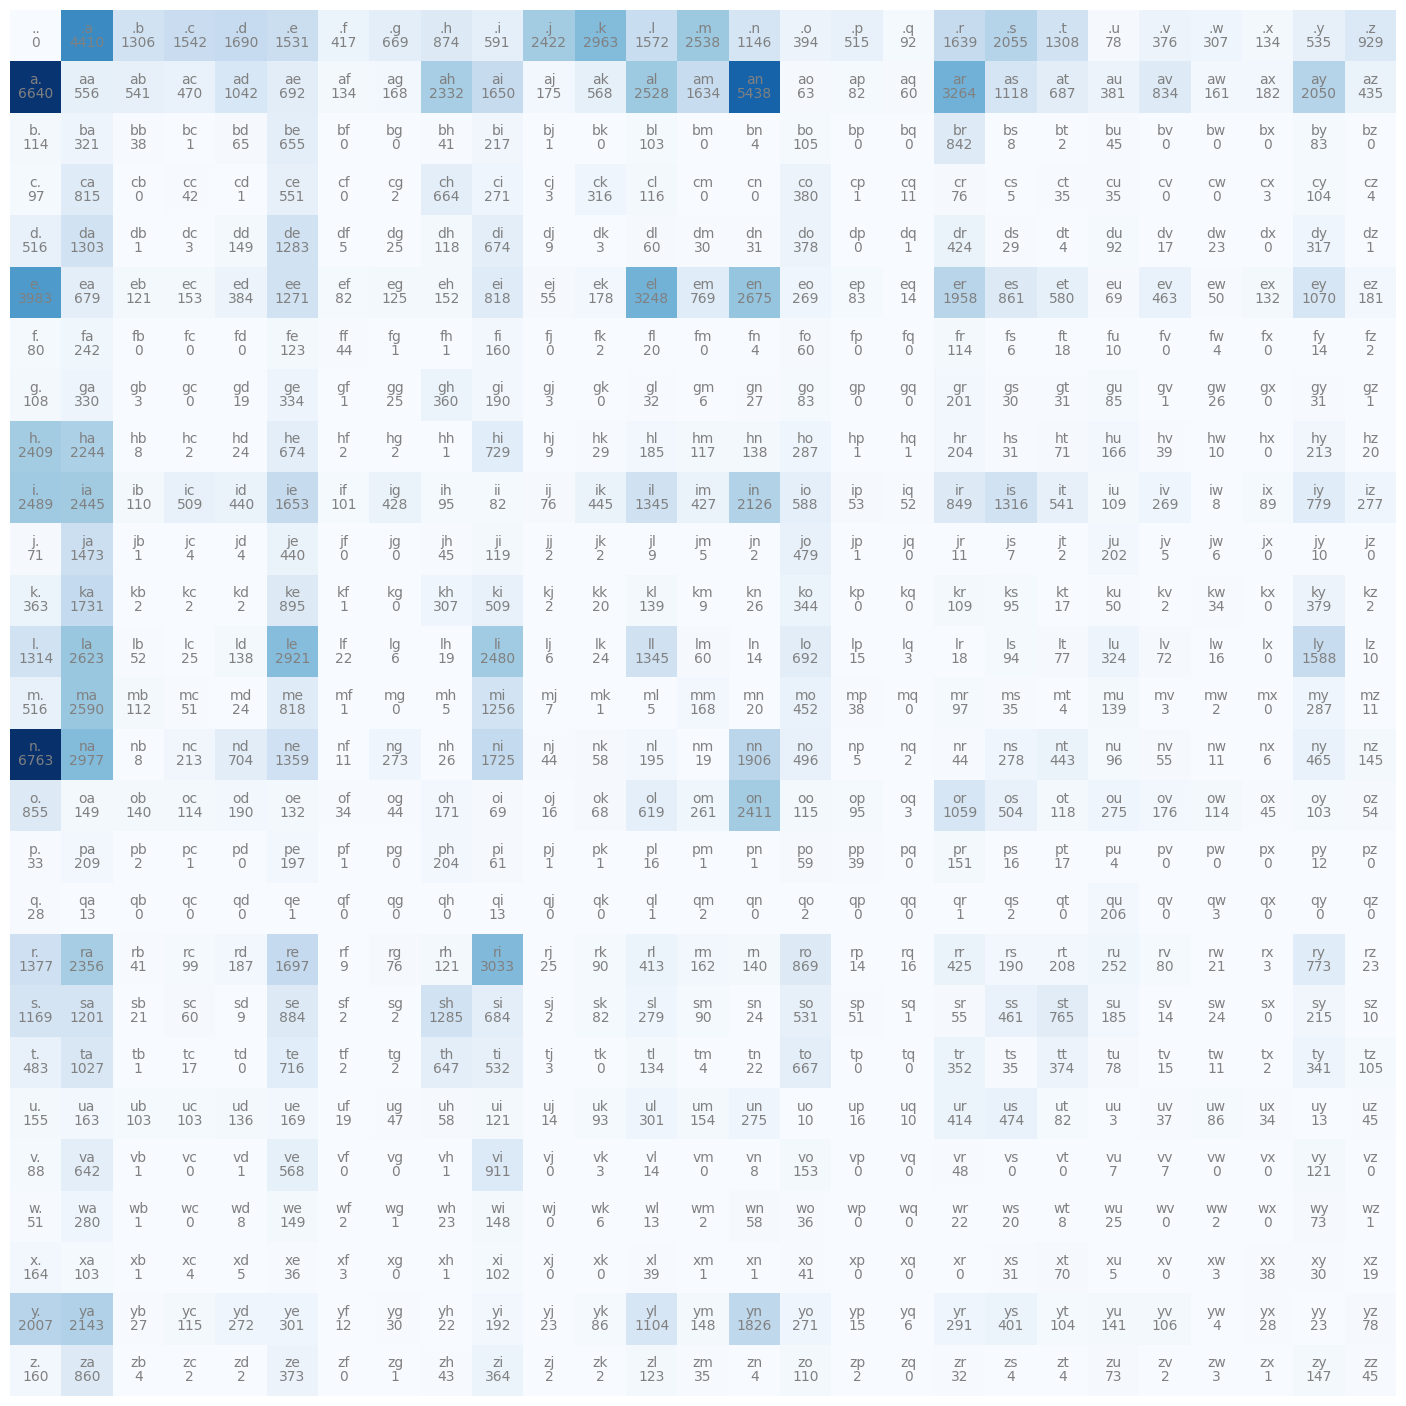

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18,18))
plt.imshow(N, cmap='Blues')

for i in range(27):
  for j in range(27):
    chstr = itos[i] + itos[j]
    # i and j seams to be in wrong order, but matplot works with an cartesian system
    plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
    plt.text(j, i, N[i, j].item(), ha ="center", va="top", color="gray")
plt.axis('off');

# Introducing negative log likelihood

In [ ]:
# Now we want to work with floats and introduce smoothing
# We can also smooth probabilities with N+m
P = (N+1).float()

# Also we calculate emission probabilitis
P/=P.sum(dim=1, keepdim = True)

In [ ]:
P[0].sum()

tensor(1.)

In [ ]:
log_likelihood = 0.0
n = 0

for w in words:
# for w in ["max"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1][ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood = }')

log_likelihood = tensor(-10.1821)


In [ ]:
# nll -> negative log likelihood
nll = -log_likelihood
print(f'{nll = }')

nll = tensor(10.1821)


In [ ]:
# average negative log likelyhood
print(n)
nll/n

4


tensor(2.5455)

# Generating names with Bigram

In [ ]:
g = torch.Generator().manual_seed(2147483647)

names = []

for i in range(30):
  out=[]

  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples = 1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  names.append(out)

for w in names:
  print(''.join(w))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.
dgossmitan.
il.
le.
pann.
that.
janreli.
isa.
dyn.
rijelumemahaunayaleva.
cararr.


# Train a NN 🤖

In [ ]:
import torch.nn.functional as F

In [ ]:
# create dataset
xs, ys = [],[]
#print(words[:1])
for w in words:
  chs = ['.'] + list(w) + ['.']
  #print(chs_list)
  for ch1, ch2 in zip(chs, chs[1:]):
    #print(ch1, ch2)
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
# print(xs)
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator = g, requires_grad= True)

number of examples:  228146


In [ ]:
xs[:30], ys[:30]

(tensor([ 0,  5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9,
         19,  1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9]))

In [ ]:
# W follows a normal distribution
W.mean(), W.std()

(tensor(0.0167, grad_fn=<MeanBackward0>),
 tensor(1.0277, grad_fn=<StdBackward0>))

In [ ]:
# gradient decent
for k in range(10):
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  # logits gonna be the rows of W depending wich classes the one-hot codings define
  # more or less those are the emission probabilites for the transitions - after getting counts and then probs
  logits = xenc @ W # predict log-counts
  # logits is counts.log(): W exponentiated W.exp() is the Bigram Array N
  counts = logits.exp() # counts, eqvivalent to N
  # which neuron will activate most likely for the input class
  probs = counts / counts.sum(dim = 1, keepdims = True)
  # With addition of + 0.01*(W**2).mean() the model now tries to make all weigths zeros for minimizing the loss (works like a spring force)
  loss = -probs[torch.arange(num), ys].log().mean() #+ 0.01*(W**2).mean()

  print(loss.item())

  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()

  #update
  #W.data += -0.1 * W.grad
  W.data += -50 * W.grad

  #print(probs.shape)
  #print(counts.shape)

2.547365665435791
2.543415069580078
2.5397486686706543
2.536336660385132
2.5331544876098633
2.5301804542541504
2.5273969173431396
2.5247862339019775
2.522334337234497
2.520028829574585


In [ ]:
xenc.shape

torch.Size([228146, 27])

In [ ]:
xenc[:3]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# Generate Samples with form NN/ model

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):

  out = []
  ix = 0
  while True:
    # -----
    # Before
    #p = P[ix]
    # -----
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes = 27). float() # input to the network: one-hot encoding«
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equvivalent to N
    p = counts / counts.sum(dim =1, keepdim=True) # probabilities for next character
    # -----

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator = g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cony.
a.
